### Momentum 10 month  Test
众多文章如Meb Faber2007年写的论文， 都指出10个月的移动均值（Moving Average）可以有效的判断市场方向的转变， 并可以在市场开始走低时，将投资头寸转移到现金上， 从而避免了大幅度的回撤和潜在损失。 

首先， 我们测试一下这个投资策略：有两个投资工具 － SPY和TLT－美国20年期的国债ETF。
* 当SPY的价格P(now) > P(10m), 全部投资SPY
* 否则全部投资TLT

In [1]:
import sys, os
sys.path.append('..')
from Data.TimeSeries import *
from ETF.AAA import *

from Data import factors
import Quandl
import pandas as pd
import matplotlib

import cvxopt as opt
from cvxopt import blas, solvers


%matplotlib inline

/Users/jianboxue/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
tickers = [ 'GOOG/NYSE_SPY', #标普500
            'GOOG/NYSEARCA_TLT', #美国20年期国债ETF
            'GOOG/NYSEARCA_GLD'
            ]

ticker_spy = 'GOOG/NYSE_SPY'
ticker_tlt = 'GOOG/NYSEARCA_TLT'
ticker_gld = 'GOOG/NYSEARCA_GLD'


ts = TimeSeries(Settings())
dp = ts.get_agg_data(tickers)
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)

KeyError: 'Date'

In [554]:
df_price_monthly = ts.filtering(dp[:, :, 'price'], 20)
signal_10m = df_price_monthly[ticker_spy] > df_price_monthly[ticker_spy].shift(10)

df_return_monthly = df_price_monthly.pct_change()
df_return_monthly['ret_1'] = df_return_monthly[ticker_spy] * signal_10m.shift(1)
df_return_monthly['ret_2'] = df_return_monthly[ticker_tlt] * (1-signal_10m).shift(1)
df_return_monthly['ret'] = df_return_monthly['ret_1'] + df_return_monthly['ret_2']

我们可以看到这个策略规避了几次主要的市场暴跌：2001-2003年， 2008－2009年， 2012年， 以及现在2016年。 在2001-2003年的互联网泡沫危机中， 这个策略及时从高点离开， 同时由于债券的反弹， 使得该策略大幅领先SPY。在2008-2010年的金融海啸中， 策略同样及时从高点离开市场。 然后由于美国国债在此期间的表现并没有十分突出， 导致在离开SPY投资TLT中并没有获得超额回报。 2012年的欧债危机，策略同样段时间离开SPY，而这次市场下跌是暂时的。所以当策略离场投资TLT的同时， SPY很快反弹，使得策略的净值曲线与SPY的距离拉近。 

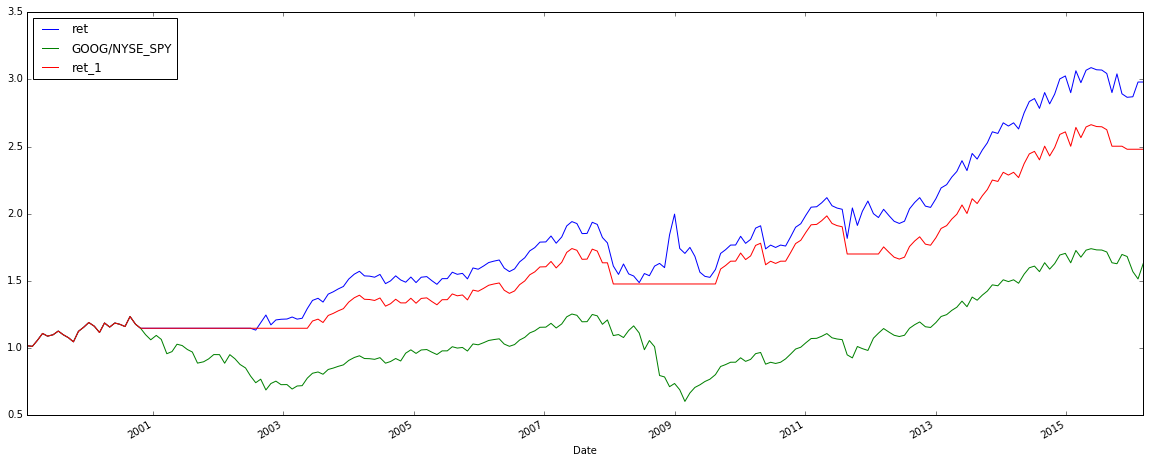

In [555]:
(1+df_return_monthly['1999-01-01'::][['ret', ticker_spy, 'ret_1']]).cumprod().plot(figsize=[20,8])

### 策略变种1: 
如果我们将10个月的周期，改变为2，4，6， 8个月， 对比回报，发现6个月的回报有很大提高

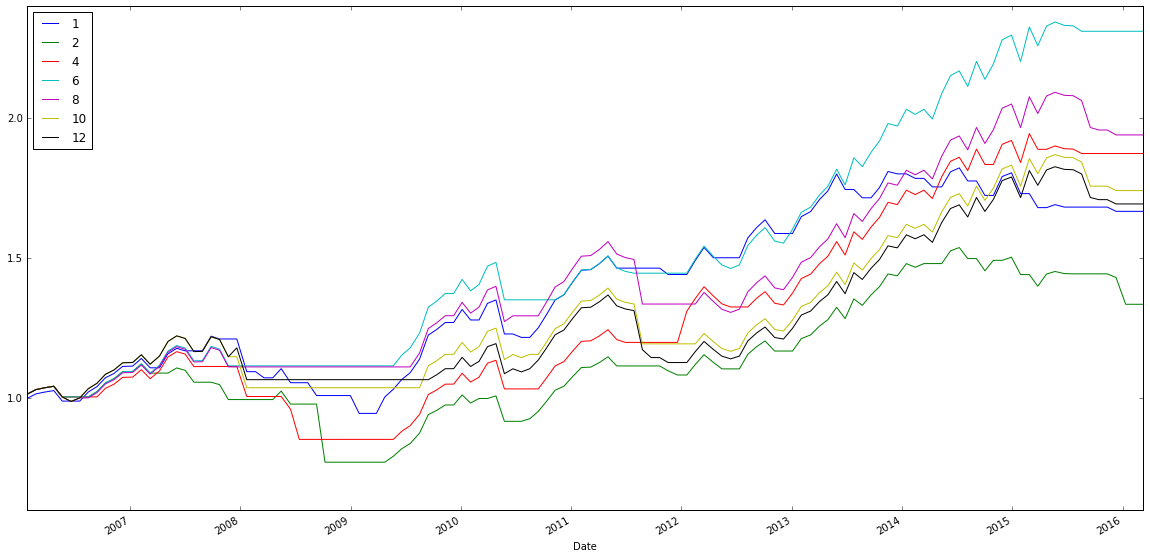

In [556]:
signals = pd.DataFrame()
rets = pd.DataFrame()
intervals = [1,2,4, 6, 8, 10, 12]
ret_spy = df_return_monthly[ticker_spy]
ret_tlt = df_return_monthly[ticker_tlt]

for i in intervals:
    signals[str(i)] = df_price_monthly[ticker_spy] > df_price_monthly[ticker_spy].shift(i)
    rets[str(i)] = ret_spy * signals[str(i)].shift(1) #+ ret_tlt * (1-signals[str(i)]).shift(1)
    
(1+rets['2006-01-01'::]).cumprod().plot(figsize=[20, 10])

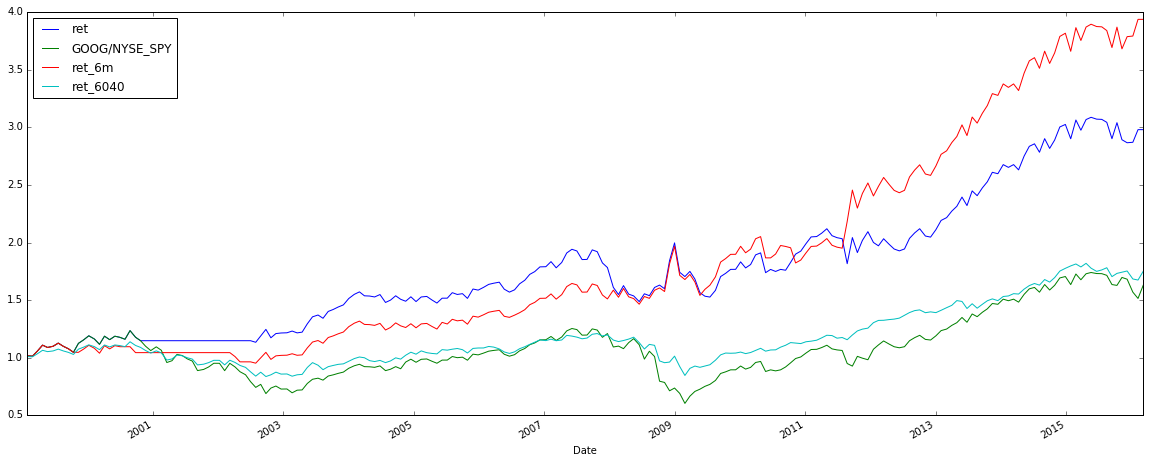

In [557]:
signal_6m = df_price_monthly[ticker_spy] > df_price_monthly[ticker_spy].shift(6)
df_return_monthly['ret_6m'] = df_return_monthly[ticker_spy] * signal_6m.shift(1) \
    + df_return_monthly[ticker_tlt] * (1-signal_6m).shift(1)
df_return_monthly['ret_6040'] = df_return_monthly[ticker_spy] * 0.6 + df_return_monthly[ticker_tlt] * 0.4
(1+df_return_monthly['1999-01-01'::][['ret', ticker_spy, 'ret_6m', 'ret_6040']]).cumprod().plot(figsize=[20,8])

## 黄金的作用
通常黄金有两个投资作用：避险，和对抗通涨。 当股票市场进入熊市或崩盘时， 资金就会离开股票市场，购买黄金避险。 而当市场对通货膨胀的忧虑加剧时， 资金也同样会买入黄金。 

所以我们可以有一个假设： 当SPY下跌，而同时


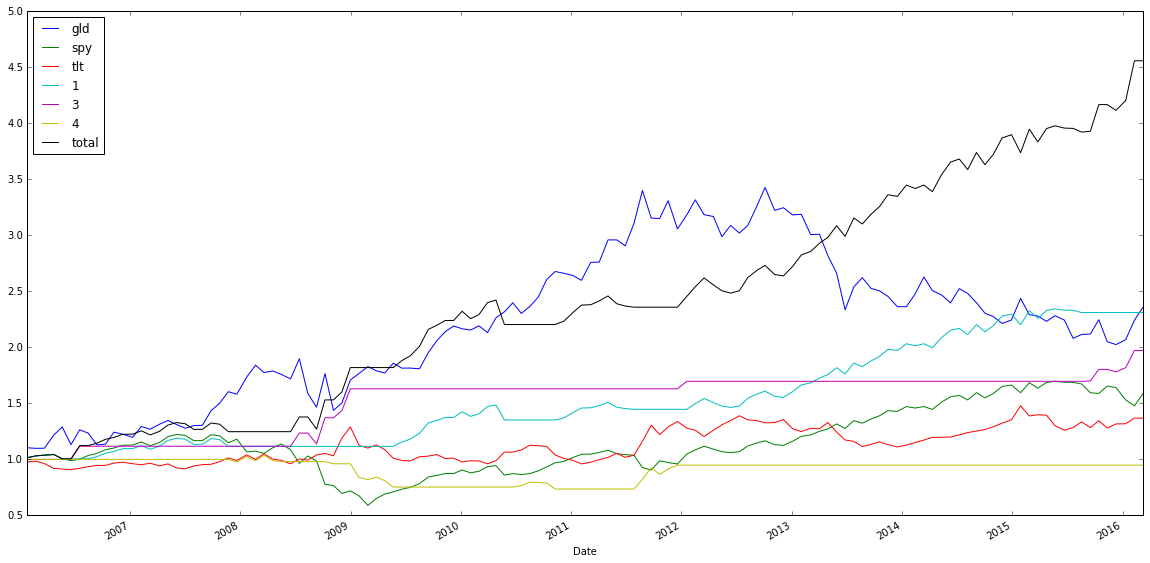

In [558]:
signal_gld = df_price_monthly[ticker_gld] < pd.rolling_mean(df_price_monthly[ticker_gld], 6)
signal_spy = df_price_monthly[ticker_spy] > df_price_monthly[ticker_spy].shift(6)
signal_tlt = df_price_monthly[ticker_tlt] > df_price_monthly[ticker_tlt].shift(6)

rets_gld = pd.DataFrame()
rets_gld['gld'] = df_return_monthly[ticker_gld]
rets_gld['spy'] = df_return_monthly[ticker_spy]
rets_gld['tlt'] = df_return_monthly[ticker_tlt]
rets_gld['1'] = rets_gld['spy'] * signal_spy.shift(1) 
rets_gld['3'] = rets_gld['gld'] * (1-signal_spy).shift(1) * signal_gld.shift(1)
rets_gld['4'] = rets_gld['tlt'] * (1-signal_spy).shift(1) * (1-signal_gld).shift(1) * signal_tlt.shift(1)
rets_gld['total'] = rets_gld['1'] + rets_gld['3'] 
(1+rets_gld['2006-01-01'::]).cumprod().plot(figsize=[20,10])

## 板块轮动：
根据前面的分析， 我们可以通过当前SPY价格与6个月前价格的比较，有效的判断市场处于上升还是下降的阶段。 当市场处于上升阶段时，我们应该加大对市场的风险敞口 － beta。 目前我们的策略是100%持有SPY， 也就是beta为1。而不同的板块在牛市的状态下，有超出市场回报的，也有低于市场回报的。 我们应该在这个阶段选择超出市场回报，beta>1的板块。 这样就可以放大在牛市状态下，策略的回报率。 

我们这里采用了一个经典的板块轮动方法： 这里是用9个S&P的板块ETFs，加上SPY。 每个月，比较10个ETF的回报（12个月的回报）。从中选出前1/2的ETF
和最强的ETF，并分别创建两个投资策略：Max和TopOnes。 前1/2的ETF的组合里面采用平均的权重配比。 

In [586]:
sector_tickers = ['GOOG/NYSEARCA_XLB',
           'GOOG/NYSEARCA_XLE', 
           'GOOG/NYSEARCA_XLF',
           'GOOG/NYSEARCA_XLI',
           'GOOG/NYSEARCA_XLK',
           'GOOG/NYSEARCA_XLP', 
           'GOOG/NYSEARCA_XLU', 
           'GOOG/NYSEARCA_XLV', 
           'GOOG/NYSEARCA_XLY', 
            ticker_spy,
            ticker_gld]


ts = TimeSeries(Settings())
dp = ts.get_agg_data(sector_tickers)
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)

df_price_monthly = ts.filtering(dp[:, :, 'price'], 20)
df_return_monthly = df_price_monthly.pct_change()

In [593]:
df_ret_sectors = pd.DataFrame()
signal_spy = df_price_monthly[ticker_spy] > df_price_monthly[ticker_spy].shift(6)
signal_6m = df_price_monthly > df_price_monthly.shift(12)

df_ret_6m = (df_price_monthly / df_price_monthly.shift(12) - 1)
signal_6m_tops = df_ret_6m.T > df_ret_6m.mean(axis=1)
signal_6m = df_ret_6m > 0
signal_6m_max = df_ret_6m.T == df_ret_6m.max(axis=1)

df_6m  = (df_return_monthly * signal_6m.shift(1)).sum(axis=1) / signal_6m.shift(1).sum(axis=1)
df_6m_avg = (df_return_monthly * signal_6m_tops.T.shift(1)).sum(axis=1) / signal_6m_tops.T.shift(1).sum(axis=1)
df_6m_max = (df_return_monthly * signal_6m_max.T.shift(1)).sum(axis=1)

Max组合的回报率最高， 其次为TopOnes， Avg和普通的SPY择时比较相差无几。 然后Max的回撤和波动性都相对加大， 综合而言TopOnes为最佳。 

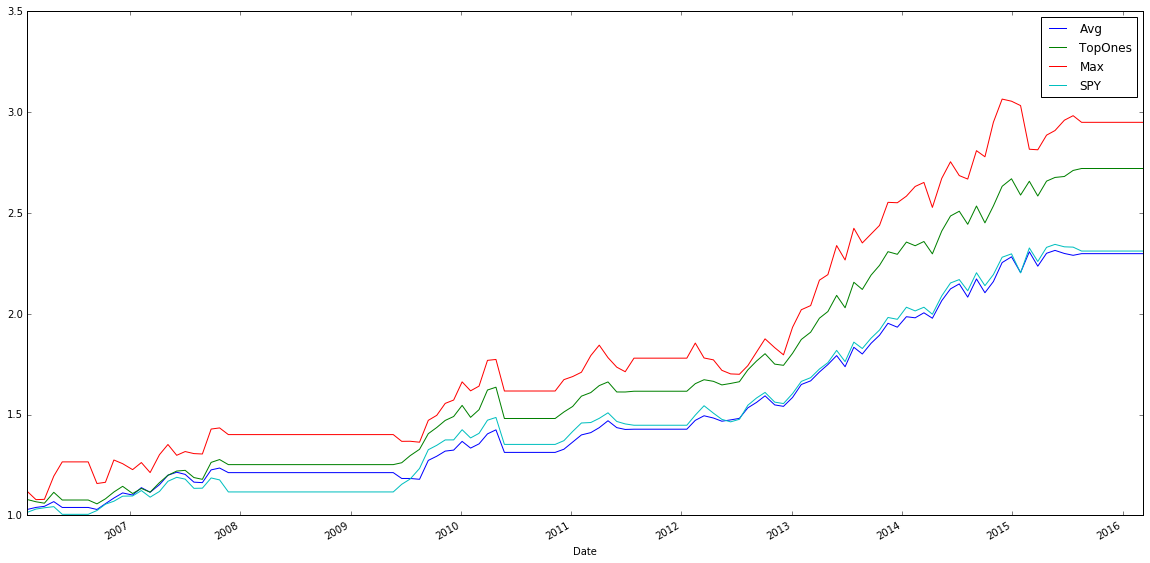

In [600]:
df_str1 = pd.DataFrame()
df_str1['Avg'] = df_6m * signal_spy.shift(1)
df_str1['TopOnes'] = df_6m_avg * signal_spy.shift(1)
df_str1['Max'] = df_6m_max * signal_spy.shift(1)
df_str1['SPY'] = df_return_monthly[ticker_spy] * signal_spy.shift(1)
df_str1 = df_str1.fillna(0)
(1+df_str1['2006-01-01'::]).cumprod().plot(figsize=[20,10])

我们将上面3个策略，与黄金对冲策略相结合：

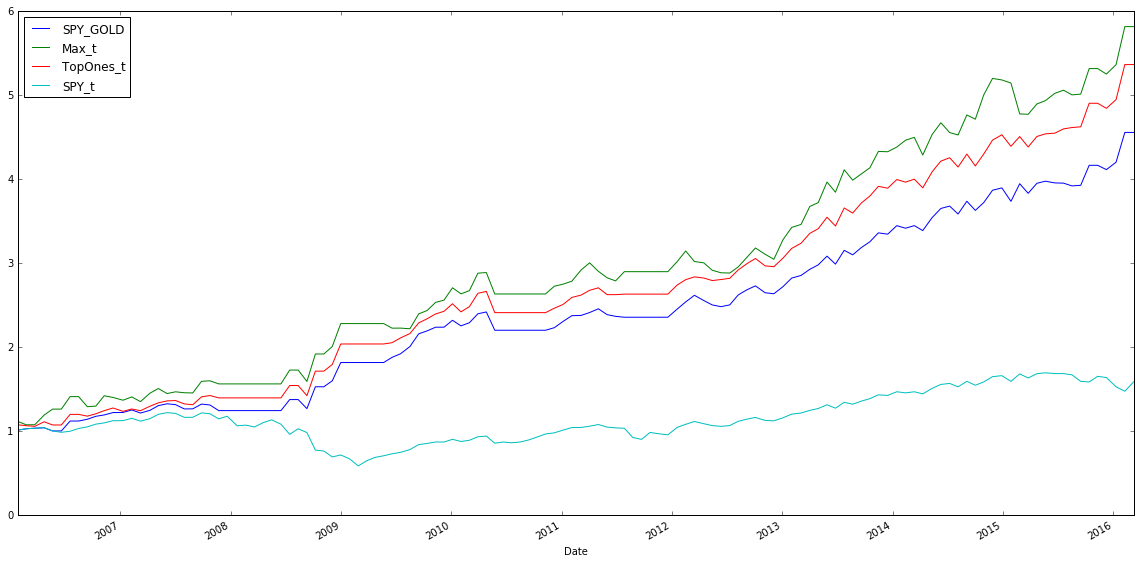

In [601]:
df_str1['SPY_GOLD'] = rets_gld['total']
df_str1['Max_t'] = df_str1['Max'] + rets_gld['3'] 
df_str1['TopOnes_t'] = df_str1['TopOnes'] + rets_gld['3']
df_str1['SPY_t'] = rets_gld['spy']
(1+df_str1['2006-01-01'::][['SPY_GOLD', 'Max_t', 'TopOnes_t', 'SPY_t']]).cumprod().plot(figsize=[20,10])

## 宏观经济参数择时 Growth Timing
通过几类宏观经济指标的增长，判断市场的牛熊状态。 继而通过MA10来决定入仓出仓时机。 

In [18]:
tickers = [ 'GOOG/NYSE_SPY', #标普500
            'GOOG/NYSEARCA_TLT', #美国20年期国债ETF
            'GOOG/NYSEARCA_GLD'
            ]

ticker_spy = 'GOOG/NYSE_SPY'
ticker_tlt = 'GOOG/NYSEARCA_TLT'
ticker_gld = 'GOOG/NYSEARCA_GLD'


ts = TimeSeries(Settings())
dp = ts.get_agg_data(tickers)
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)

df_indices = dp[:,:,'price']

In [21]:
df_indices.index.min()

Timestamp('1997-08-21 00:00:00+0000', tz='UTC')

In [86]:
# 下载fred宏观经济增长指标
fred_tickers = pd.read_csv('./fred_index.csv')['free_code']
print fred_tickers
dp_fred = ts.get_agg_Fred_data(fred_tickers)
df_fred = dp_fred[:,:, 'value']

df_fred = df_fred.shift(1) # Fred data is reported with one month lag, we therefore shift the data forward
df_fred = df_fred[df_indices.index.min()::]
df_fred_ret = (df_fred - df_fred.shift(12))/df_fred

0     FRED/RRSFS
1    FRED/INDPRO
2    FRED/PAYEMS
3       FRED/RPI
4     FRED/HOUST
Name: free_code, dtype: object


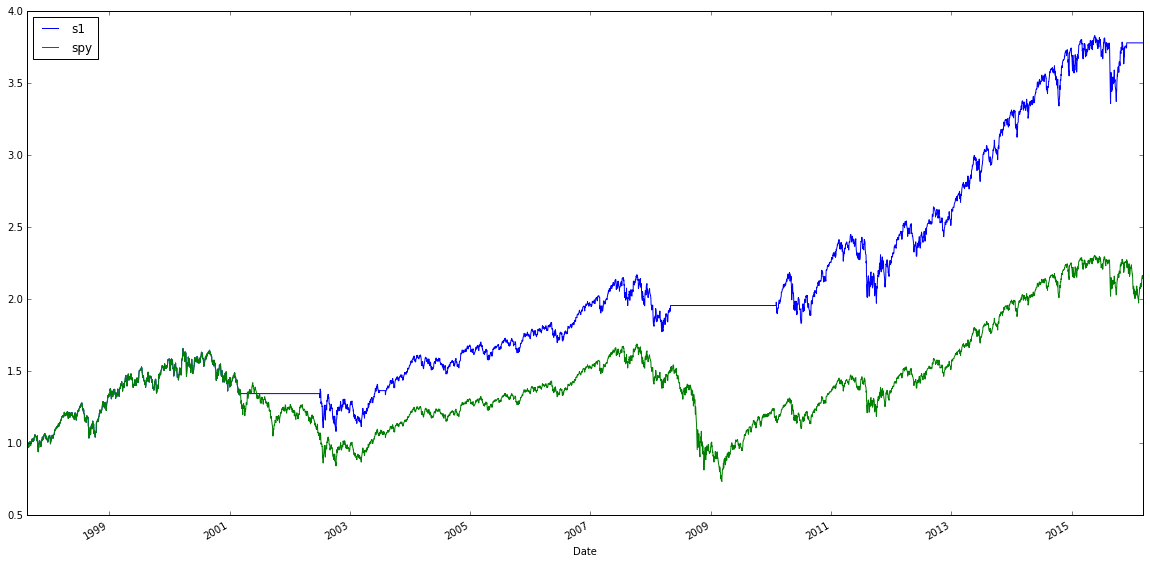

In [94]:
# 将两个dataframe合并
df = df_fred_ret.join(df_indices, how='outer')
df = df.fillna(method='ffill', axis=0)
df = df.fillna(method='bfill', axis=0)

#df_ret = df.pct_change().dropna()

df_strategy = pd.DataFrame()
df_strategy['spy'] = df[ticker_spy].pct_change()
df_strategy['s1'] = df_strategy['spy'] * (df[fred_tickers[1]] > 0).shift(1)

(1+df_strategy[['s1', 'spy']]).cumprod().plot(figsize=[20,10])

## 相关性分析


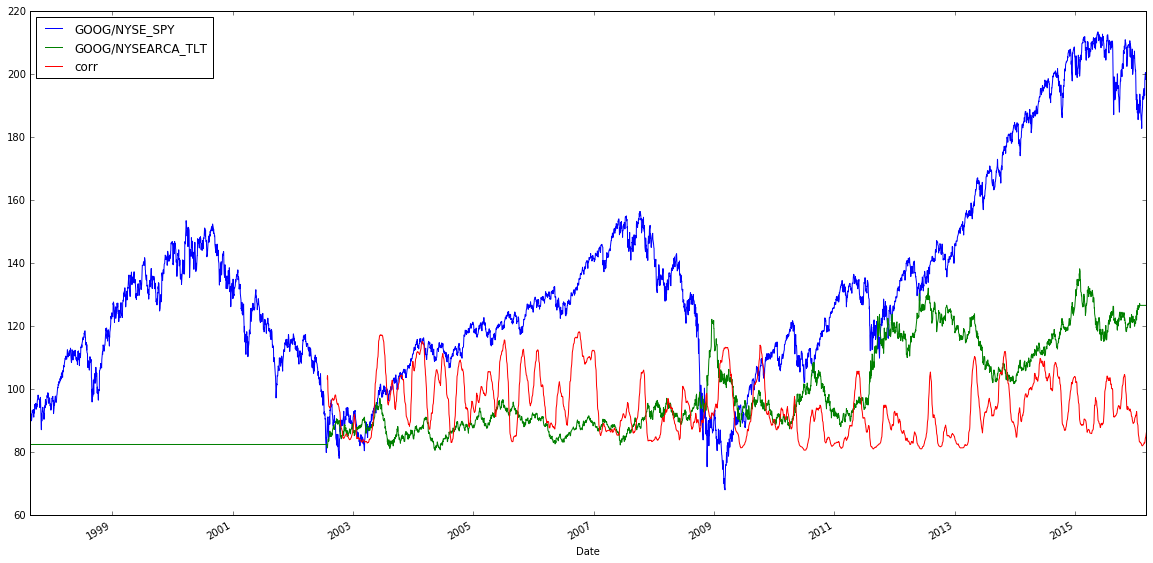

In [49]:
spy = pd.DataFrame()
spy = dp[:, :, 'price']
corr_list = pd.rolling_corr(spy, 60)
# spy['ret'] = spy['price'].pct_change()

# spy_m = ts.filtering(spy, 20)
spy['corr'] = corr_list[:,ticker_spy, ticker_tlt]
spy[[ticker_spy, ticker_tlt, 'corr']].plot(figsize=[20,10])

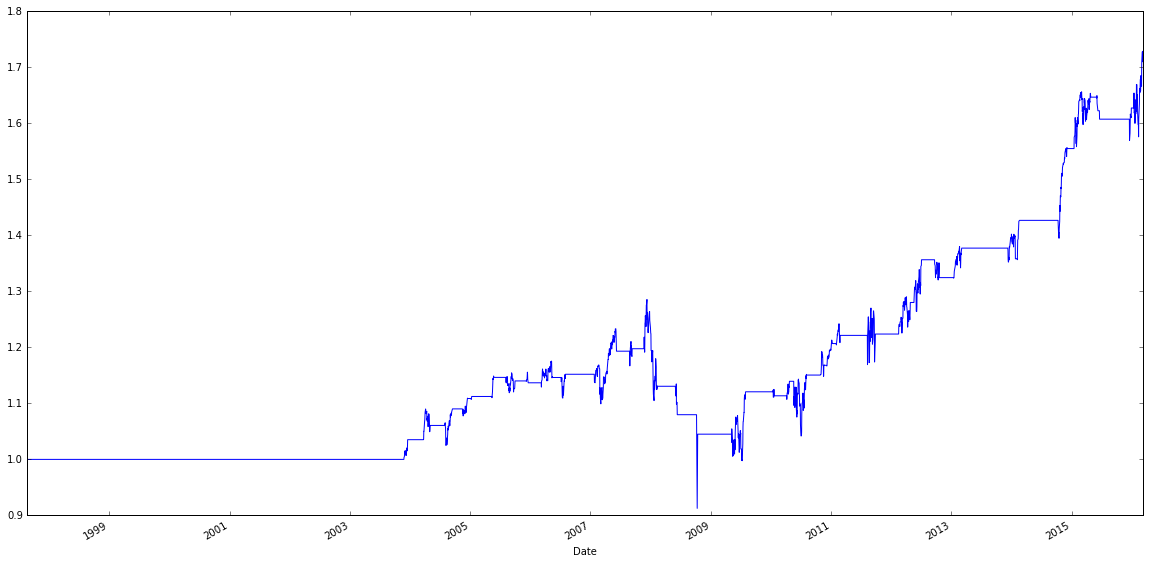

In [83]:
signal_corr = spy['corr'] < pd.rolling_quantile(spy['corr'], 200, 0.3)
ret_str = spy[ticker_spy].pct_change() * signal_corr.shift(1)
(1+ret_str).cumprod().plot(figsize=[20,10])
# (spy[ticker_spy].pct_change() * signal.shift(1)).plot()

In [ ]:
signal = spy['corr'] < pd.rolling_quantile

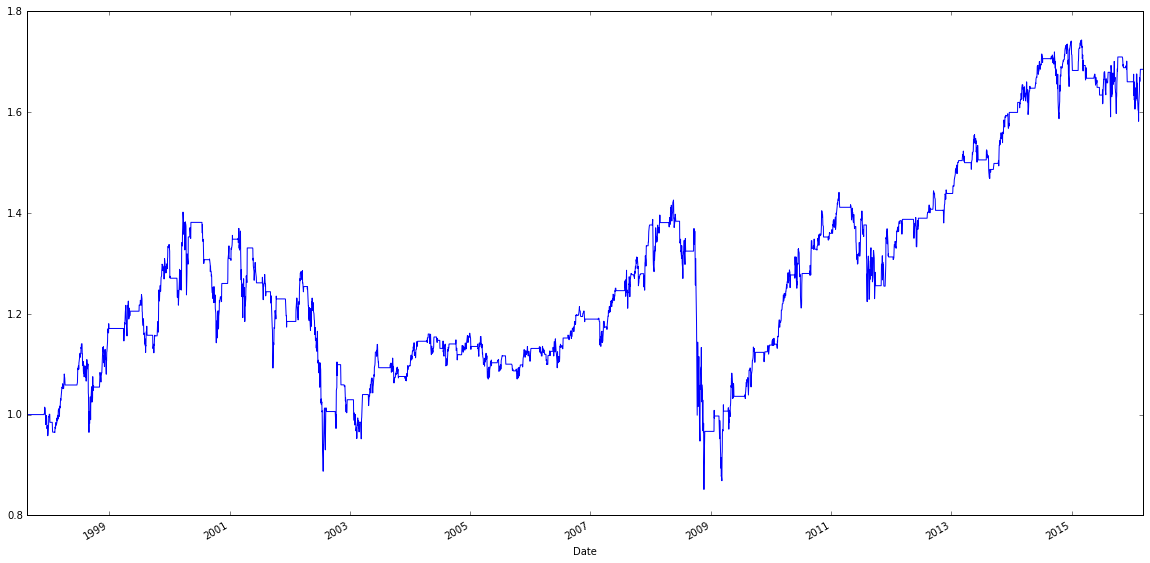

In [32]:
spy['ret_str'] = spy['ret'] * (spy['vol'] > pd.rolling_mean(spy['vol'], 10)).shift(1)
(1+spy['ret_str']).cumprod().plot(figsize=[20,10])

# 

In [100]:
a = ts.get_agg_data(tickers)

In [102]:
a[tickers[0], :, :]

,open,high,low,close,volume,price
Date,,,,,,
1997-08-21 00:00:00+00:00,0.00,94.25,92.09,92.59,5392600,92.59
1997-08-22 00:00:00+00:00,0.00,92.73,90.56,92.56,7172900,92.56
1997-08-25 00:00:00+00:00,0.00,93.41,91.84,92.22,3888000,92.22
1997-08-26 00:00:00+00:00,0.00,92.56,90.70,90.86,4290000,90.86
1997-08-27 00:00:00+00:00,0.00,91.97,90.41,91.41,5484300,91.41
1997-08-28 00:00:00+00:00,0.00,91.94,90.00,90.02,4287900,90.02
1997-08-29 00:00:00+00:00,0.00,91.11,89.72,90.38,2652300,90.38
1997-09-02 00:00:00+00:00,0.00,93.36,90.59,93.31,7294000,93.31
1997-09-03 00:00:00+00:00,0.00,94.00,92.75,92.81,2812500,92.81
